In [2]:
#importing required python libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Activation, RepeatVector
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 

In [3]:
# loading and  displaying dataset
dataset = pd.read_csv('Dataset/DarknetCopy.csv')
dataset



,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,ACK Flag Count,Down/Up Ratio,Average Packet Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Idle Mean,Traffic Type,Traffic Category
0,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,Non-Tor,Audio-Streaming
1,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,Non-Tor,Audio-Streaming
2,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,Non-Tor,Audio-Streaming
3,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,Non-Tor,Audio-Streaming
4,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,...,991,0,71.948537,0,65,0,6,1.440000e+15,Non-Tor,Audio-Streaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141525,10.8.8.246,55219,224.0.0.252,5355,17,411806,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,VPN,VOIP
141526,10.8.8.246,64207,224.0.0.252,5355,17,411574,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,VPN,VOIP
141527,10.8.8.246,61115,224.0.0.252,5355,17,422299,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,VPN,VOIP
141528,10.8.8.246,64790,224.0.0.252,5355,17,411855,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,VPN,VOIP


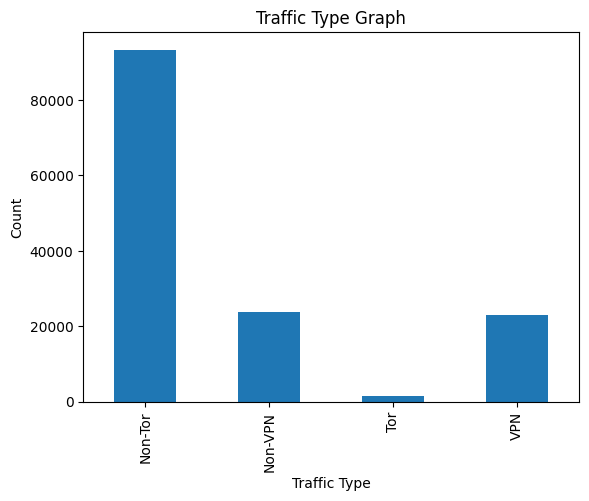

In [4]:
# plotting graph with differnet traffic types found in dataset
traffic_type, traffic_count = np.unique(dataset['Traffic Type'], return_counts=True)
label = dataset.groupby('Traffic Type').size()
label.plot(kind="bar")
plt.xlabel("Traffic Type")
plt.ylabel("Count")
plt.title("Traffic Type Graph")
plt.show()


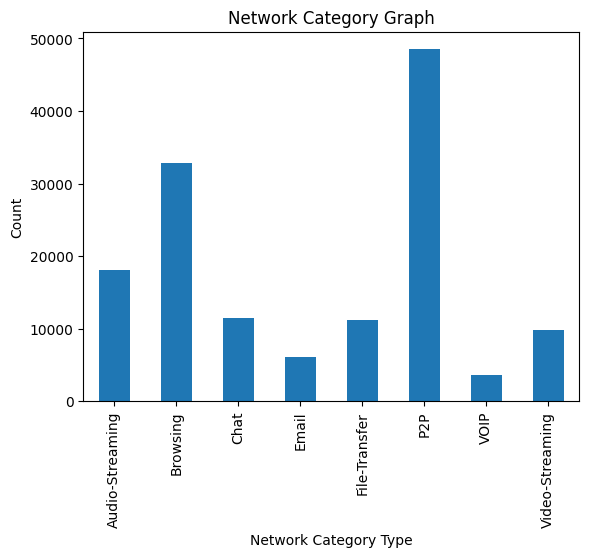

In [5]:
# plotting graph with differnet network categories found in dataset
category_type, category_count = np.unique(dataset['Traffic Category'], return_counts=True)
label = dataset.groupby('Traffic Category').size()
label.plot(kind="bar")
plt.xlabel("Network Category Type")
plt.ylabel("Count")
plt.title("Network Category Graph")
plt.show()

In [6]:
# replacing categorical values with numerical values using Label Encoding

# handling inf values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(0, inplace = True) # hanling nan values

label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for i in range(len(types)):
    name = types[i]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str))) #encode all str columns to numeric 
        label_encoder.append(le)
dataset        

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,ACK Flag Count,Down/Up Ratio,Average Packet Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Idle Mean,Traffic Type,Traffic Category
0,13,57158,3431,443,6,229,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,0,0
1,13,57159,3431,443,6,407,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,0,0
2,13,57160,3431,443,6,431,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,0,0
3,13,49134,5811,443,6,359,1,1,0,0,...,2,1,0.000000,0,0,0,0,0.000000e+00,0,0
4,13,34697,1661,19305,6,10778451,591,400,64530,6659,...,991,0,71.948537,0,65,0,6,1.440000e+15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141525,24,55219,3501,5355,17,411806,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,3,6
141526,24,64207,3501,5355,17,411574,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,3,6
141527,24,61115,3501,5355,17,422299,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,3,6
141528,24,64790,3501,5355,17,411855,2,0,44,0,...,0,0,33.000000,1,22,0,0,0.000000e+00,3,6


In [7]:
# data preprocessing steps
data = dataset.values
X = data[:,0:data.shape[1]-2] #extracting X --> data packet information
Y1 = data[:,data.shape[1]-2] # extracting first target class
Y2 = data[:,data.shape[1]-1] # extracting second target class

Y1 = Y1.astype(int)
Y2 = Y2.astype(int)

indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffling the dataset
X = X[indices]
Y1 = Y1[indices]
Y2 = Y2[indices]

#normalizing or scaling values
scaler = StandardScaler()
X = scaler.fit_transform(X)

#reshape dataset as 3 dimenssion
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
Y1 = to_categorical(Y1)
Y2 = to_categorical(Y2)

# splitting dataset into train and test data {4:1}
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.2) 
print()
print("Total records found in dataset : "+str(X.shape[0]))
print("Training Size (80%): "+str(X_train1.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test1.shape[0]))
print()




Total records found in dataset : 141530
Training Size (80%): 113224
Testing Size (20%): 28306



In [8]:
# function to calculate performance analysis of the model
def calculateMetrics(algorithm, model, predict, testY):
    testY = testY.astype('int')
    predict = predict.astype('int')

    # performance metrics
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict)*100 
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FSCORE      : '+str(f))

    # confusion matrix to visualize the relativity b/w test class & predicted class
    conf_matrix = confusion_matrix(testY, predict) 
     
    
    if model == 1:
        plt.figure(figsize =(5, 5))
        ax = sns.heatmap(conf_matrix, xticklabels = traffic_type, yticklabels = traffic_type, annot = True, cmap="viridis" ,fmt ="g");
        ax.set_ylim([0,len(traffic_type)])
        plt.title(algorithm+" Confusion matrix") 
        plt.ylabel('True class') 
        plt.xlabel('Predicted class') 
    else:
        plt.figure(figsize =(10, 7))
        ax = sns.heatmap(conf_matrix, xticklabels = category_type, yticklabels = category_type, annot = True, cmap="viridis" ,fmt ="g");
        ax.set_ylim([0,len(category_type)])
        plt.title(algorithm+" Confusion matrix") 
        plt.ylabel('True class') 
        plt.xlabel('Predicted class') 
    # plt.tight_layout()
    plt.show()

885/885 [==============================] - 2s 2ms/step

AutoEncoder Accuracy  : 95.15297110153324
AutoEncoder Precision   : 92.55876398547682
AutoEncoder Recall      : 84.5369898937252
AutoEncoder FSCORE      : 87.98354628166545


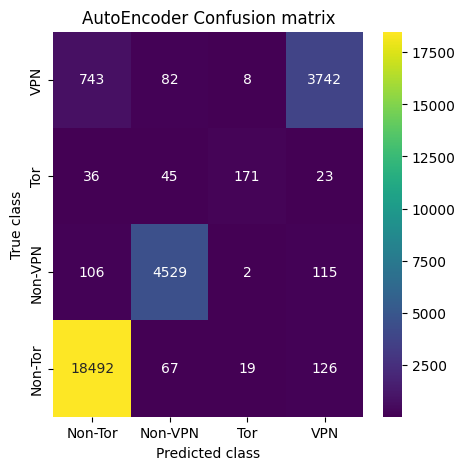

In [9]:
# AutoEncoder model architecture definition for predicting first target class

# encoder part of model is created using cnn
auto_enc_dec = Sequential()
# cnn layer with 32 neurons or filters to filter and encode dataset features
auto_enc_dec.add(Conv1D(filters=32, kernel_size=9, activation='relu', input_shape=(X_train1.shape[1], X_train1.shape[2])))
# another layer with 16 neurons to further filter features
auto_enc_dec.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
# max pool layer to collect filtered features from CNN
auto_enc_dec.add(MaxPooling1D(pool_size=2))

#convert multidimension features to single dimension
auto_enc_dec.add(Flatten())
auto_enc_dec.add(RepeatVector(2))

# decoder part of model is created using lstm
auto_enc_dec.add(LSTM(16, activation='relu'))
# defining output layer with 100 neurons
auto_enc_dec.add(Dense(units = 8, activation = 'relu'))
auto_enc_dec.add(Dense(units = 4, activation = 'softmax'))

#compile the model
auto_enc_dec.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and load the model
# it also saves the updated weights of network in hdf5 format
if os.path.exists("model/encoder_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/encoder_weights.hdf5', verbose = 1, save_best_only = True)
    hist = auto_enc_dec.fit(X_train1, y_train1, batch_size = 256, epochs = 5, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
else:
    auto_enc_dec.load_weights("model/encoder_weights.hdf5")
# category_model = load_model("model/encoder_category_weights.hdf5")    
predict = auto_enc_dec.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("AutoEncoder", 1, predict, testY)


885/885 [==============================] - 2s 2ms/step

AutoEncoder Accuracy  : 81.49508938034339
AutoEncoder Precision   : 73.70420773363695
AutoEncoder Recall      : 63.131136258433386
AutoEncoder FSCORE      : 64.19283464724327


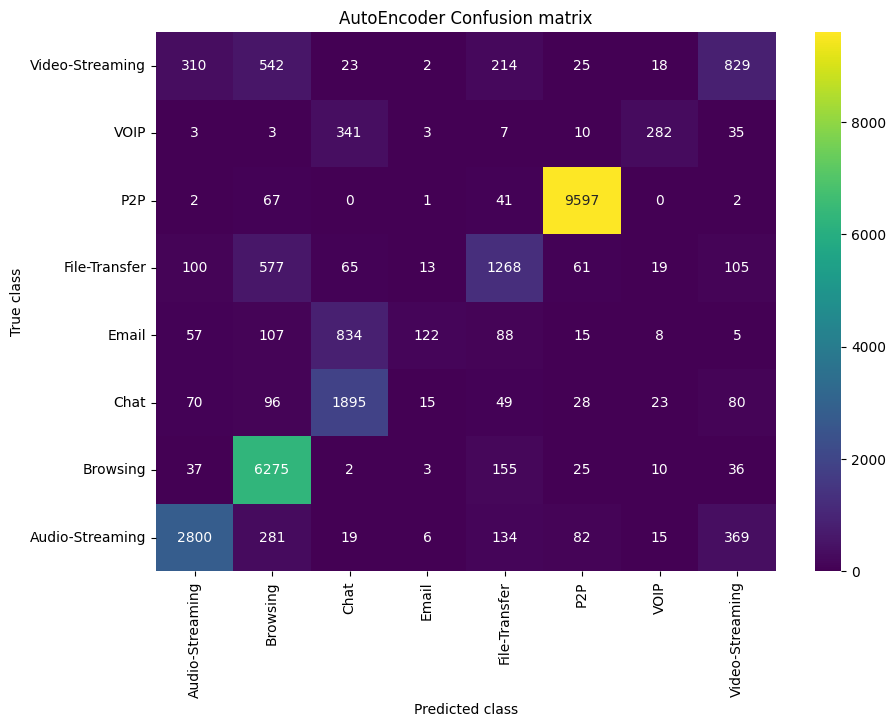

In [10]:
# AutoEncoder model architecture definition for predicting second target class

# encoder part of model is created using cnn
auto_enc_dec2 = Sequential()
# cnn layer with 32 neurons or filters to filter and encode dataset features
auto_enc_dec2.add(Conv1D(filters=32, kernel_size=9, activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2])))
# another layer with 16 neurons to further filter features
auto_enc_dec2.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
# max pool layer to collect filtered features from CNN
auto_enc_dec2.add(MaxPooling1D(pool_size=2))

#convert multidimension features to single dimension
auto_enc_dec2.add(Flatten())
auto_enc_dec2.add(RepeatVector(2))

# decoder part of model is created using lstm
auto_enc_dec2.add(LSTM(32, activation='relu'))
# defining output layer with 100 neurons
auto_enc_dec2.add(Dense(units = 100, activation = 'relu'))
auto_enc_dec2.add(Dense(units = 8, activation = 'softmax'))

#compile the model
auto_enc_dec2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and load the model
# it also saves the updated weights of network in hdf5 format
if os.path.exists("model/encoder_category_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/encoder_category_weights.hdf5', verbose = 1, save_best_only = True)
    hist = auto_enc_dec2.fit(X_train2, y_train2, batch_size = 256, epochs = 10, validation_data=(X_test2, y_test2), callbacks=[model_check_point], verbose=1)
else:
    auto_enc_dec2.load_weights("model/encoder_category_weights.hdf5")
# category_model = load_model("model/encoder_category_weights.hdf5")    
predict = auto_enc_dec2.predict(X_test2)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test2, axis=1)
calculateMetrics("AutoEncoder", 2, predict, testY)


In [36]:

data = pd.read_csv('example.csv')  # loading test data
dataset = data
dataset.fillna(0, inplace=True)  # removing missing values
dataset = dataset.sample(frac = 1)
index = 0
columns = dataset.columns
types = dataset.dtypes.values
label_encoder = []  # initializing an empty list of label encoders
for i in range(len(types)):
    name = types[i]
    if name == 'object':
        if len(label_encoder) <= index:  # checking if the label encoder list needs to be extended
            label_encoder.append(LabelEncoder())
        dataset[columns[i]] = pd.Series(label_encoder[index].fit_transform(dataset[columns[i]].astype(str)))
        index = index + 1

dataset = dataset.values
x = scaler.transform(dataset)  # normalizing values
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
traffic_type_predict = auto_enc_dec.predict(x)  # performing prediction on test data
network_category = auto_enc_dec2.predict(x)
for i in range(len(x)):
    print("Traffic Test Data : " + str(dataset[i]))
    print("Predicted Traffic Type : " + traffic_type[int(np.argmax(traffic_type_predict[i]))])
    print("Predicted Network Category : " + category_type[int(np.argmax(network_category[i]))])
    print()


3/3 [==============================] - 0s 4ms/step
Traffic Test Data : [7.00000000e+00 4.43000000e+02 1.00000000e+00 5.19700000e+04
 6.00000000e+00 2.24719000e-01 4.00000000e+01 3.00000000e+00
 1.00000000e+00 3.01300000e+03 7.90000000e+01 7.50000000e+01
 0.00000000e+00 2.00000000e+00 1.00000000e+00 2.42810545e+01
 1.10179021e+01 8.00000000e+00 3.20000000e+01 6.52674205e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.25114116e+02 0.00000000e+00 2.69000000e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Predicted Traffic Type : Non-Tor
Predicted Network Category : Email

Traffic Test Data : [7.00000000e+00 4.43000000e+02 1.00000000e+00 5.19690000e+04
 6.00000000e+00 5.00179000e-01 4.00000000e+01 6.00000000e+01
 2.00000000e+00 3.00000000e+01 0.00000000e+00 7.50000000e+01
 4.33836905e+01 2.90000000e+01 1.00000000e+00 1.00000000e+00
 1.10179021e+01 2.00000000e+01 0.00000000e+00 6.52674205e+00
 3.49003993e+00 1.00000000e+00 0.00000000e+00 1.20000000e+01
